In [1]:
%matplotlib inline

In [32]:
import glob
from astropy.table import Table, Column
from astropy.io import fits
from collections import Counter
from __future__ import absolute_import, division, print_function

import os
from collections import Counter
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column, join

import astropy.constants
c = astropy.constants.c.to('km/s').value

from desitarget.targets import desi_mask
from desisim.quickcat import quickcat
import matplotlib.pyplot as plt


### Looking for targets that were in fiberassign, but missing in zcat

In [33]:
base_path = "/home/forero/Data/desitest/lowfat/" 
tile_names = glob.glob(base_path + "/4/fiberassign/tile_*.fits")
nobs = Counter()
desitarget = np.empty((), dtype='int64')
targetid_fiber = np.empty((), dtype='int64')
for tile_file in tile_names:
    fibassign = Table.read(tile_file, hdu=1)
    ii = (fibassign['TARGETID'] != -1) 
    nobs.update(fibassign['TARGETID'][ii])
    desitarget = np.append(desitarget, np.array(fibassign['DESI_TARGET'][ii]))
    targetid_fiber = np.append(targetid_fiber, np.array(fibassign['TARGETID'][ii]))

print(len(nobs.keys()), len(targetid_fiber), len(desitarget))
print(targetid_fiber[:10])
targets = Table.read("/home/forero/Data/desitest/mtl/targets.fits")
truth = Table.read("/home/forero/Data/desitest/mtl/truth.fits")
mtl = Table.read(base_path+"/4/mtl.fits")
zcat = Table.read(base_path+"/4/zcat.fits")

527892 528209 528209
[         2857291600 1250363948574008178 3609159208931471375
  719950519532907646  798326793562667321 3308266609191736861
 3036135859017821979  170300333330830609 1463945693497080320
 3560111010812678752]


In [34]:
print(fibassign.colnames, len(targets['TARGETID']))

['FIBER', 'POSITIONER', 'NUMTARGET', 'PRIORITY', 'TARGETID', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'RA', 'DEC', 'XFOCAL_DESIGN', 'YFOCAL_DESIGN'] 2947950


In [35]:
ids_fiber = list(nobs.keys())
ids_mtl = list(mtl['TARGETID'])
ids_truth = list(truth['TARGETID'])
ids_targets = list(targets['TARGETID'])
ids_zcat = list(zcat['TARGETID'])

In [36]:
def find_missing(list_A, list_B): # |list_A| > |list_B|
    a = list(set(list_A) & set(list_B)) #find the intersection
    missing = list(set(list_B) - set(a)) #find B minus the intersection
    return missing #these are the IDs in B that are missing in A

In [37]:
missing = find_missing(ids_targets, ids_mtl)
print(len(missing))
missing = find_missing(ids_targets, ids_fiber)
print(len(missing))
missing = find_missing(ids_mtl, ids_fiber)
print(len(missing))
missing = find_missing(list(set(targetid_fiber)), ids_fiber)
print(len(missing))
missing = find_missing(ids_truth, ids_fiber)
print(len(missing))
missing = find_missing(ids_zcat, ids_fiber)
print(len(missing))

0
66533
66533
0
66533
66533


The ```Counter(c[iiobs])``` tells us that in fact the missing targets are sky and standard stars. Nothing to worry.

In [38]:
a = np.array(targetid_fiber, dtype='int64')
b = np.array(missing)
c = np.array(desitarget, dtype='int64')
print(len(a), len(b), len(c))
iiobs = np.in1d( a, b)
#print(a, b)
print(Counter(c[iiobs]))
l  = nobs.keys()
l.sort()
b.sort()
print(l[-5:])
print(b[-5:])

528209 66533 528209
Counter({4294967296: 53480, 8589934592: 13369})
[4611657991589602018, 4611659834770750312, 4611666440557552276, 4611682077800766603, 4611682678262325494]
[4611415134407046794 4611454756065059442 4611470019085638056
 4611550344386585230 4611558383850489773]


### Checking that the number of observations is correctly propagated

(Based on S. Bailey code)

In [39]:
targets = Table.read("/home/forero/Data/desitest/mtl/targets.fits")
truth = Table.read("/home/forero/Data/desitest/mtl/truth.fits")

In [40]:
#- truth and targets are row-matched, so directly add columns instead of join
for colname in targets.colnames:
    if colname not in truth.colnames:
        truth[colname] = targets[colname]

In [41]:
print (truth.colnames)

['TARGETID', 'BRICKNAME', 'RA', 'DEC', 'TRUEZ', 'TRUETYPE', 'CATEGORY', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'SUBPRIORITY']


In [42]:
Counter(zip(truth['DESI_TARGET'], truth['TRUETYPE']))

Counter({(1, 'GALAXY'): 291029,
         (1, 'UNKNOWN'): 48639,
         (2, 'GALAXY'): 2354756,
         (4, 'QSO'): 165428,
         (4, 'STAR'): 88098})

In [43]:
iilrg = ((truth['DESI_TARGET'] & desi_mask.LRG) != 0) & (truth['TRUETYPE'] == 'GALAXY')
iielg = ((truth['DESI_TARGET'] & desi_mask.ELG) != 0) & (truth['TRUETYPE'] == 'GALAXY')
iiqso = ((truth['DESI_TARGET'] & desi_mask.QSO) != 0) & (truth['TRUETYPE'] == 'QSO')

lrg = truth[iilrg]
elg = truth[iielg]
qso = truth[iiqso]

In [44]:
print('LRG', len(lrg))
print('ELG', len(elg))
print('QSO', len(qso))

LRG 291029
ELG 2354756
QSO 165428


In [45]:
zcat4 = Table.read(base_path+'/4/zcat.fits', 1)
zcat5 = Table.read(base_path+'/5/zcat.fits', 1)

In [46]:
def count_obs(zcat):
    obslrg = np.in1d(lrg['TARGETID'], zcat['TARGETID'])
    obselg = np.in1d(elg['TARGETID'], zcat['TARGETID'])
    obsqso = np.in1d(qso['TARGETID'], zcat['TARGETID'])
    print('LRG {:4f}'.format(np.count_nonzero(obslrg) / len(lrg)))
    print('ELG {:4f}'.format(np.count_nonzero(obselg) / len(elg)))
    print('QSO {:4f}'.format(np.count_nonzero(obsqso) / len(qso)))

In [47]:
print('zcat4')
count_obs(zcat4)
print('')
print('zcat5')
count_obs(zcat5)

zcat4
LRG 0.950053
ELG 0.734103
QSO 0.982264

zcat5
LRG 0.874061
ELG 0.678528
QSO 0.984525


In [48]:
x4 = join(zcat4, truth, keys='TARGETID')
x5 = join(zcat5, truth, keys='TARGETID')

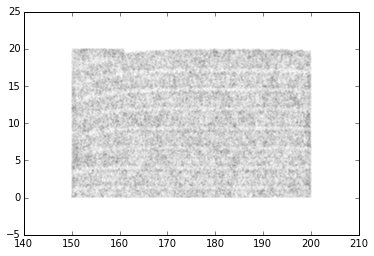

In [49]:
missing = np.array(list(set(x5['TARGETID']) - set(x4['TARGETID'])))
ii = np.in1d(truth['TARGETID'], missing)
plt.scatter(truth['RA'][ii], truth['DEC'][ii], s=0.0001)

In [50]:
import os.path
def filename2tileid(filename):
    filename = os.path.basename(filename)
    tileid = filename[5:10]
    return tileid

#- load all tiles
from glob import glob
tiles = dict()
for i in [4,3,2,1,0]:
    for tilefile in glob('{}/{}/fiberassign/tile*.fits'.format(base_path,i)):
        tileid = filename2tileid(tilefile)
        if tileid not in tiles:
            tiles[tileid] = Table.read(tilefile, 1)
            tiles[tileid]['TILEID'] = tileid

In [51]:
fa = Table(np.concatenate(tiles.values()))
#- Keep only ELG, LRG, QSO targets (not calib or unassigned)
ii = (fa['DESI_TARGET'] & desi_mask.mask('ELG|LRG|QSO')) != 0
fa = fa[ii]

In [52]:
#- load pass 5 tiles
t5 = list()
for tilefile in glob(base_path+'/5/fiberassign/tile*.fits'):
    tileid = filename2tileid(tilefile)
    tx = Table.read(tilefile)
    tx['TILEID'] = tileid
    t5.append(tx)
fa5 = Table(np.concatenate(t5))
ii = (fa5['DESI_TARGET'] & desi_mask.mask('ELG|LRG|QSO')) != 0
fa5 = fa5[ii]

In [53]:
len(zcat4), len(fa), len(zcat5), len(fa5)

(2300515, 2782990, 2144585, 2874112)

In [54]:
#- Find the targets that are in fiber assignments but not zcat
nozcat = ~np.in1d(fa['TARGETID'], zcat4['TARGETID'])

In [55]:
#- about the same number of fibers assigned for 0-4 vs. 5
#- and very few missing targets (why any?)
#- many more re-observations?
np.count_nonzero(nozcat), len(nozcat)

(2, 2782990)

In [56]:
from collections import Counter
c4 = Counter(fa['TARGETID'])
c5 = Counter(fa5['TARGETID'])

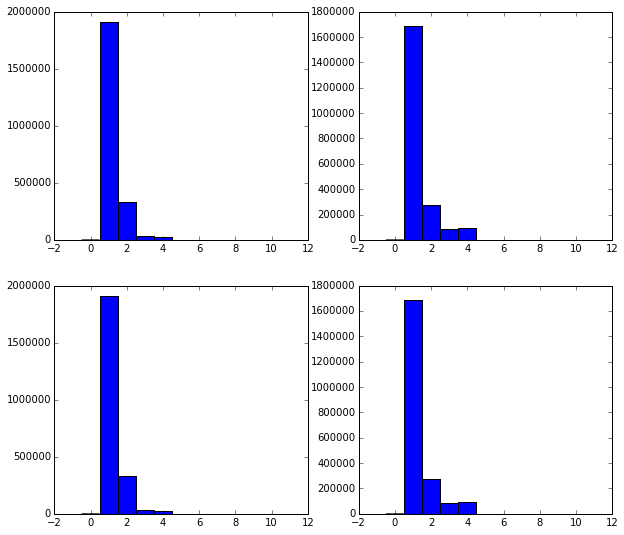

In [57]:
plt.figure(figsize=(10.0,9.0))
plt.subplot(221); n_z4 = plt.hist(zcat4['NUMOBS'], 11, (-0.5,10.5))
plt.subplot(222); n_z5 = plt.hist(zcat5['NUMOBS'], 11, (-0.5,10.5))
plt.subplot(223); n_c4 = plt.hist(c4.values(), 11, (-0.5,10.5))
plt.subplot(224); n_c5 = plt.hist(c5.values(), 11, (-0.5,10.5))

In [58]:
# zcat and fiberassign nobs should be the same on each for each epoch

print("zcat {} fiberassign {}".format(n_z5[0][1:6], n_c5[0][1:6]))
print("zcat {} fiberassign {}".format(n_z4[0][1:6], n_c4[0][1:6]))

zcat [ 1689364.   276601.    82938.    95682.        0.] fiberassign [ 1689364.   276601.    82938.    95683.        0.]
zcat [ 1908511.   330395.    32749.    28860.        0.] fiberassign [ 1908511.   330396.    32749.    28860.        0.]


In [59]:
def print_counter(ll):
    total = np.sum(ll.values())
    for k in ll.keys():
        print("\t {}: {} ({} total)".format(desi_mask.names(k), ll[k]/total, ll[k]))

In [60]:
# what are the galaxy types that got only one observation at the end of the day?

for times_observed in range(1,6):
    print('Target fraction for exactly {} observations'.format(times_observed))

    print('\t PASS 4')
    ii = (x4['NUMOBS']==times_observed)
    print_counter(Counter(x4['DESI_TARGET'][ii]))

    print('\t PASS 5')
    ii = (x5['NUMOBS']==times_observed)
    print_counter(Counter(x5['DESI_TARGET'][ii]))
    print('')


Target fraction for exactly 1 observations
	 PASS 4
	 ['LRG']: 0.0313291356455 (59792 total)
	 ['ELG']: 0.905749560783 (1728633 total)
	 ['QSO']: 0.0629213035712 (120086 total)
	 PASS 5
	 ['LRG']: 0.044343314999 (74912 total)
	 ['ELG']: 0.945781370977 (1597769 total)
	 ['QSO']: 0.0098753140235 (16683 total)

Target fraction for exactly 2 observations
	 PASS 4
	 ['LRG']: 0.7960895292 (263024 total)
	 ['QSO']: 0.2039104708 (67371 total)
	 PASS 5
	 ['LRG']: 0.803503964194 (222250 total)
	 ['QSO']: 0.196496035806 (54351 total)

Target fraction for exactly 3 observations
	 PASS 4
	 ['QSO']: 1.0 (32749 total)
	 PASS 5
	 ['QSO']: 1.0 (82938 total)

Target fraction for exactly 4 observations
	 PASS 4
	 ['QSO']: 1.0 (28860 total)
	 PASS 5
	 ['QSO']: 1.0 (95682 total)

Target fraction for exactly 5 observations
	 PASS 4
	 PASS 5

